### Phone Recommendation System


In [1]:
import os

In [2]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\Imarticus_Learning\\12_Projects\\Phone_Recommendation_System'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class EDAConfig:
    root_dir: Path
    local_data_file: str
    STATUS_FILE_PATH: Path

In [6]:
from phone_recommender.constants import *
from phone_recommender.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

    def get_eda_config(self) -> EDAConfig:
        config = self.config.eda

        eda_config = EDAConfig(
            root_dir=config.root_dir, local_data_file=config.local_data_file, STATUS_FILE_PATH=config.STATUS_FILE_PATH
        )

        return eda_config

#### Importing Libraries


In [8]:
from phone_recommender.logging import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [9]:
class EDA:
    def __init__(self, config: EDAConfig) -> None:
        self.config = config

        create_directories([self.config.root_dir])

    def get_data(self) -> pd.DataFrame:
        data_loading_status = None

        df = pd.read_csv(self.config.local_data_file)

        if not os.path.exists(self.config.STATUS_FILE_PATH) or len(df) != 0:
            data_loading_status = True
            with open(self.config.STATUS_FILE_PATH, "w") as f:
                f.write(f"Data Loading Status: {data_loading_status}")
                logger.info(f"Data Loading in DataFrame Complete")

                return df

        else:
            data_loading_status = False
            with open(self.config.STATUS_FILE_PATH, "w") as f:
                f.write(f"Data Loading Status: {data_loading_status}")
                logger.info(f"Data Loading Failed")

    def data_preprocessing(self):
        data_processing_status = None

        if os.path.exists(self.config.STATUS_FILE_PATH):
            data_processing_status = True
            with open(self.config.STATUS_FILE_PATH, "w+") as f:
                f.write(f"Data Preprocessing Status: {data_processing_status}")
                logger.info(f"Data Preprocessing Complete.")
        else:
            logger.info(f"get_data step not complete.")

#### Step-1 Data Gathering


In [10]:
try:
    config = ConfigurationManager()
    eda_config = config.get_eda_config()
    eda = EDA(eda_config)
    df = eda.get_data()
except Exception as e:
    raise e

[2023-12-01 21:17:45,046: INFO: common: yaml file: config\config.yaml loads successfully]
[2023-12-01 21:17:45,049: INFO: common: yaml file: params.yaml loads successfully]
[2023-12-01 21:17:45,050: INFO: common: created directory at : artifacts/eda]
[2023-12-01 21:17:45,116: INFO: 3629236120: Data Loading in DataFrame Complete]


In [11]:
df.head()

,name,text
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...


#### Data Preprocessing


In [12]:
def get_bands(text):
    try:
        pattern = re.compile(r"4G bands:.*5G bands:|4G bands:.*Speed:")
        bands_4g = re.search(pattern, text)
        bands_4g = re.sub(r"4G bands:|5G bands:|Speed:", "", bands_4g.group()).strip()
        bands_4g = ",".join([char for char in bands_4g.split(", ")])
        return bands_4g
    except:
        return "No: 4G Bands"

In [13]:
df['4G_bands'] = df.text.apply(lambda x: get_bands(x))

In [14]:
df.shape

(3019, 3)

In [15]:
df.isnull().sum()

name        0
text        0
4G_bands    0
dtype: int64

In [16]:
def get_bands_count(text):
    if text == "No: 4G Bands":
        return 0
    else:
        res = [
            re.search(r"\d\d", x).group() for x in text.split(",") if len(x) > 1 and re.search(r"[0-9][0-9]", x) != None
        ]
        res2 = [re.search(r"\d", x).group() for x in text.split(",") if len(x) == 1 and re.search(r"\d", x) != None]
        res3 = [re.search(r"LTE", x).group() for x in text.split(",") if len(x) > 1 and re.search(r"LTE", x) != None]
        res = len(set(res + res2 + res3))
        return res

In [17]:
df['4G_bands_count'] = df['4G_bands'].apply(lambda x: get_bands_count(x))

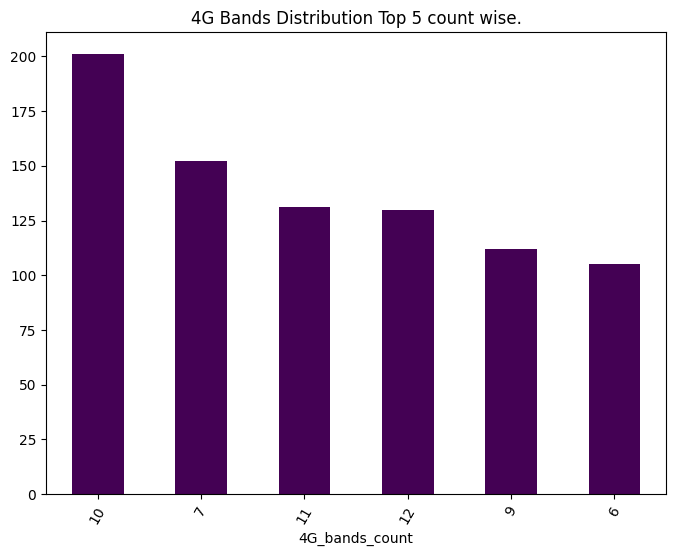

In [18]:
df['4G_bands_count'].value_counts()[1:].head(6).plot(
    kind="bar", colormap="viridis", figsize=(8, 6), fontsize="10", title="4G Bands Distribution Top 5 count wise."
)
plt.xticks(rotation=60)
plt.show()

- So from above chart:
  - we can see that most of the 4G phones have bands between 6 to 12.
  - with 10 bands being the most common choice among the all the mobile brands.


In [19]:
def get_5g_bands(text):
    try:
        pattern = re.compile(r"5G bands:.*Speed:")
        bands_5g = re.search(pattern, text)
        bands_5g = re.sub(r"4G bands:|5G bands:|Speed:|SA/NSA", "", bands_5g.group()).strip()
        bands_5g = ",".join([char for char in bands_5g.split(", ")])
        if bands_5g == "":
            return "12"
        else:
            return bands_5g
    except:
        return "No: 5G Bands"

In [20]:
df['5G_bands'] = df['text'].apply(lambda x: get_5g_bands(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands


In [21]:
df['5G_bands_count'] = df['5G_bands'].apply(lambda x: get_bands_count(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands,5G_bands_count
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands,0
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12,1
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands,0


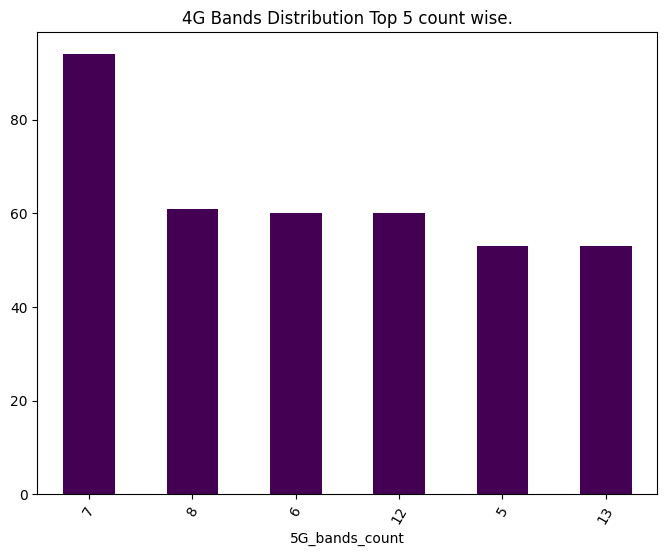

In [22]:
df['5G_bands_count'].value_counts()[1:].head(6).plot(
    kind="bar", colormap="viridis", figsize=(8, 6), fontsize="10", title="4G Bands Distribution Top 5 count wise."
)
plt.xticks(rotation=60)
plt.show()

- From above chart analysis:
  - most of the 5G phones have bands between 5 to 13.
  - with 7 being the most common choice among all the mobile brands.


In [23]:
def get_announced_date(text):
    pattern = re.compile(r"Announced:.*Status:")
    res = re.search(pattern=pattern, string=text).group()
    res = re.sub("Announced:|Status:", "", res).strip()
    return res

In [24]:
df['Announced_Date'] = df['text'].apply(lambda x: get_announced_date(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands,5G_bands_count,Announced_Date
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands,0,"2023, October 31"
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, September 08"
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12,1,"2023, September 08"
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, August 29"
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands,0,"2023, May 23"


In [25]:
def get_status(string):
    pattern = re.compile(r"Status:.*Dimensions:")
    res = re.search(pattern=pattern, string=string).group()
    res = re.sub("Status:|Dimensions:", "", res).strip()
    return res

In [26]:
df['Status'] = df['text'].apply(lambda x: get_status(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands,5G_bands_count,Announced_Date,Status
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands,0,"2023, October 31","Available. Released 2023, November 03"
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 27"
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 16"
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, August 29","Available. Released 2023, August 29"
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands,0,"2023, May 23","Available. Released 2023, June 10"


In [27]:
def get_full_dimension(string):
    pattern = re.compile(r"Dimensions:.*Weight:")
    res = re.search(pattern=pattern, string=string).group()
    res = re.sub(r"Dimensions:|Weight:|mm.*|-.*|", "", res).strip()
    return res

In [28]:
df['Full_Dimension'] = df['text'].apply(lambda x: get_full_dimension(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands,5G_bands_count,Announced_Date,Status,Full_Dimension
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands,0,"2023, October 31","Available. Released 2023, November 03",162.4 x 75.5 x 7.4
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 27",163.7 x 79 x 8.1
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 16",Unfolded: 156.9 x 141.5 x 5.3
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, August 29","Available. Released 2023, August 29",163.7 x 79 x 8.1
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands,0,"2023, May 23","Available. Released 2023, June 10",171.6 x 79.9 x 8.9


In [29]:
def get_dimensions(string):
    pattern = re.compile(r"Unfolded: |or.*| \(15\.9")
    res = re.sub(pattern, "", string).split("x")
    res = (
        [np.nan, np.nan, np.nan] if len(res) <= 2 or ('' in res) else [np.round(np.float32(x.strip()), 2) for x in res]
    )
    return pd.Series(res, index=['height', 'width', 'depth'])

In [30]:
df[['height', 'width', 'depth']] = df['Full_Dimension'].apply(lambda x: get_dimensions(x))
df.head()

,name,text,4G_bands,4G_bands_count,5G_bands,5G_bands_count,Announced_Date,Status,Full_Dimension,height,width,depth
0,nova 11 SE,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,"1,3,4,5,8,18,19,26,34,38,39,40,41",13,No: 5G Bands,0,"2023, October 31","Available. Released 2023, November 03",162.4 x 75.5 x 7.4,162.399994,75.500000,7.4
1,Mate 60 Pro+,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 27",163.7 x 79 x 8.1,163.699997,79.000000,8.1
2,Mate X5,Technology: GSM / CDMA / HSPA / EVDO / LTE / 5...,LTE,1,12,1,"2023, September 08","Available. Released 2023, September 16",Unfolded: 156.9 x 141.5 x 5.3,156.899994,141.500000,5.3
3,Mate 60 Pro,Technology: GSM / CDMA / HSPA / CDMA2000 / LTE...,LTE,1,12,1,"2023, August 29","Available. Released 2023, August 29",163.7 x 79 x 8.1,163.699997,79.000000,8.1
4,nova Y91,Technology: GSM / HSPA / LTE 2G bands: GSM 850...,"1,2,3,4,5,7,8,13,20,26,28,38,40,41,66",15,No: 5G Bands,0,"2023, May 23","Available. Released 2023, June 10",171.6 x 79.9 x 8.9,171.600006,79.900002,8.9
